# test AES encription

In [ ]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
from Crypto.Random import get_random_bytes

import numpy as np

def get_text_data():
    path = "./data/peter_pan.txt"
    example_key = get_random_bytes(32)
    cipher = AES.new(example_key, AES.MODE_EAX)

    original = []
    encrypted = []
    with open(path, 'rb') as f_in:
        while True:
            chunk = f_in.read(1456)
            if not chunk:
                break
            if len(chunk) % 16 != 0:
                chunk = pad(chunk, AES.block_size)
            encrypted_chunk = cipher.encrypt(chunk)

            # 2*data_sample/255 - 1 to map uint8s to [-1. 1] range
            original.append(2*np.frombuffer(chunk, dtype=np.uint8)/255 - 1)
            encrypted.append(2*np.frombuffer(encrypted_chunk, dtype=np.uint8)/255 - 1)
    
    original = np.array(original[:-1])
    encrypted = np.array(encrypted[:-1])

    return original, encrypted

def get_voip_data():
    path = "./data/sample3.opus"
    example_key = get_random_bytes(32)
    cipher = AES.new(example_key, AES.MODE_EAX)

    original = []
    encrypted = []
    with open(path, 'rb') as f_in:
        while True:
            chunk = f_in.read(1456)
            if not chunk:
                break
            if len(chunk) % 16 != 0:
                chunk = pad(chunk, AES.block_size)
            encrypted_chunk = cipher.encrypt(chunk)

            # 2*data_sample/255 - 1 to map uint8s to [-1. 1] range
            original.append(2*np.frombuffer(chunk, dtype=np.uint8)/255 - 1)
            encrypted.append(2*np.frombuffer(encrypted_chunk, dtype=np.uint8)/255 - 1)
    
    original = np.array(original[:-1])
    encrypted = np.array(encrypted[:-1])

    return original, encrypted

In [2]:
original, encrypted = get_text_data()
print("Original data shape:", original.shape)
print("Encrypted data shape:", encrypted.shape)


Original data shape: (179, 1456)
Encrypted data shape: (179, 1456)


# test ML models

In [3]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
original, encrypted = get_text_data()

data_size = original.shape[0]
test_size = 20
train_size = data_size - test_size


test_original = original[-test_size:]
test_encrypted = encrypted[-test_size:]
test_data = torch.tensor(np.concatenate((test_original, test_encrypted), axis=0), dtype=torch.float32).to(device)
test_labels = torch.tensor(np.array([0] * 20 + [1] * 20), dtype=torch.int64).to(device)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size=1456, num_classes=2):
        super(MLP, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        logits = self.mlp(x)
        return logits


 20%|██        | 4/20 [00:00<00:01, 15.91it/s]

Epoch [1/20], Loss: 0.2300, Test Accuracy: 0.5000
Epoch [2/20], Loss: 0.0751, Test Accuracy: 0.5000
Epoch [3/20], Loss: 0.0502, Test Accuracy: 0.9000
Epoch [4/20], Loss: 0.0332, Test Accuracy: 1.0000


 40%|████      | 8/20 [00:00<00:00, 17.55it/s]

Epoch [5/20], Loss: 0.0226, Test Accuracy: 1.0000
Epoch [6/20], Loss: 0.0164, Test Accuracy: 1.0000
Epoch [7/20], Loss: 0.0144, Test Accuracy: 1.0000
Epoch [8/20], Loss: 0.0104, Test Accuracy: 1.0000


 60%|██████    | 12/20 [00:00<00:00, 18.24it/s]

Epoch [9/20], Loss: 0.0090, Test Accuracy: 1.0000
Epoch [10/20], Loss: 0.0087, Test Accuracy: 1.0000
Epoch [11/20], Loss: 0.0061, Test Accuracy: 1.0000
Epoch [12/20], Loss: 0.0088, Test Accuracy: 1.0000


 80%|████████  | 16/20 [00:00<00:00, 18.60it/s]

Epoch [13/20], Loss: 0.0044, Test Accuracy: 1.0000
Epoch [14/20], Loss: 0.0042, Test Accuracy: 1.0000
Epoch [15/20], Loss: 0.0030, Test Accuracy: 1.0000
Epoch [16/20], Loss: 0.0039, Test Accuracy: 1.0000


100%|██████████| 20/20 [00:01<00:00, 17.43it/s]


Epoch [17/20], Loss: 0.0033, Test Accuracy: 1.0000
Epoch [18/20], Loss: 0.0038, Test Accuracy: 1.0000
Epoch [19/20], Loss: 0.0031, Test Accuracy: 1.0000
Epoch [20/20], Loss: 0.0020, Test Accuracy: 1.0000


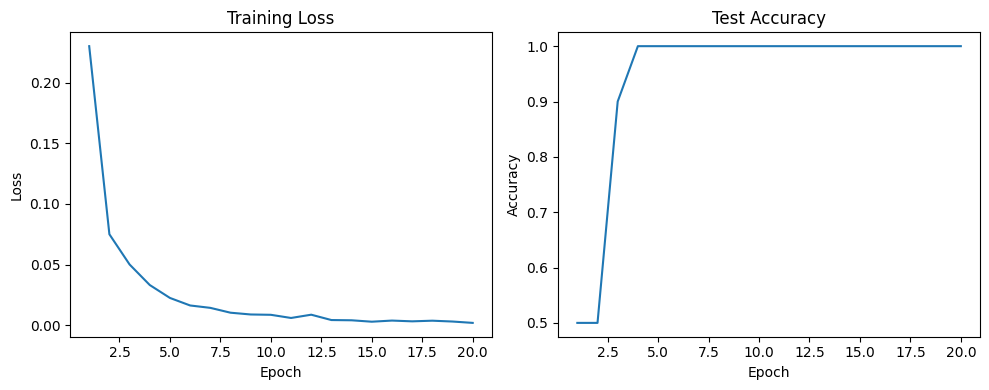

In [18]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

num_epochs = 20
batch_size = 32
test_size = 20


# model, criterion, optimizer
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_accuracies = []
# training loop
for epoch in tqdm(range(num_epochs)):
    original, encrypted = get_text_data()
    data_size = original.shape[0]
    
    # split into train/test
    train_original = original[:-test_size]
    train_encrypted = encrypted[:-test_size]

    train_data = torch.tensor(
        np.concatenate((train_original, train_encrypted), axis=0), 
        dtype=torch.float32
    ).to(device)
    train_labels = torch.tensor(
        np.array([0] * train_original.shape[0] + [1] * train_encrypted.shape[0]), 
        dtype=torch.int64
    ).to(device)

    train_dataloader = DataLoader(
        TensorDataset(train_data, train_labels),
        batch_size=batch_size,
        num_workers=0,
        shuffle=True,
    )
    
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    
    # Training phase
    # for data, labels in tqdm(train_dataloader, leave=False):
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / batch_count
    train_losses.append(avg_loss)
    
    # Evaluation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_data)
        _, predicted = torch.max(test_outputs.data, 1)
        accuracy = (predicted == test_labels).sum().item() / test_labels.size(0)
        test_accuracies.append(accuracy)
    
    tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Plot training progress
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
